# Proyecto 03 - Sistemas de Recomendación

## Dataset: STEAM

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset. Sin embargo, **deberás** modificarlas para hacer un mejor manejo de datos. Algunas cosas a las que deberás prestar atención (tal vez no a todas):
1. Tipos de datos: elige tipos de datos apropiados para cada columna.
2. Descartar columnas poco informativas.
3. Guardar en memoria datasets preprocesados para no tener que repetir código que tarde en correr.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿cuáles son los juegos más populares?¿Y los menos populares?

### Filtro Colaborativo

Deberás implementar un sistema de recomendación colaborativo para este dataset. Ten en cuenta:

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.

Puedes implementar un filtro colaborativo a partir de la similitud coseno o índice de Jaccard. ¿Puedes utilizar los métodos de la librería Surprise? Si no es así, busca implementaciones (por ejemplo, nuevas librerías) que sean apropiadas.

Para comenzar a trabajar, puedes asumir que cada entrada es un enlace entre una persona usuaria y un item, **independientemente** de si la crítica es buena o mala. 

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo harías para ponerle un valor a la calificación?
1. ¿Cómo harías para agregar contenido? Por ejemplo, cuentas con el género, precio, fecha de lanzamiento y más información de los juegos.
1. ¿Hay algo que te gustaría investigar o probar?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt
import gzip
from matplotlib import rcParams
from scipy.stats import norm
import gc #garbage collector
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise import SVD

In [2]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

In [3]:
contador = 0
data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
n = 10
for l in parse('steam_reviews.json.gz'):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1 

### Reviews dataframe

In [4]:
data_reviews = pd.DataFrame(data_reviews)

#evitamos que los product_id aparezcan con notación cientrífica
pd.options.display.float_format = '{:.1f}'.format
#borramos duplicados
data_reviews.drop_duplicates(subset=['product_id', 'user_id'], keep='last')

data_reviews.head()

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,nan
1,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,nan
2,freakfantom,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,nan
3,The_Cpt_FROGGY,7.8,2217.0,631920,0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False,1,76561198003030375,Product received for free,nan
4,the_maker988,8.2,18.0,35140,7,2018-01-02,"This game was way to linear for me, and compar...",False,1,76561198353396844,NaN,nan


In [5]:
#creo una copia para utilizar en la investigacion del ultimo punto
datain = data_reviews

### Games dataframe

In [6]:
data_games = []
for l in parse('steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

In [7]:
data_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.5,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],5.0,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",nan,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",nan,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.8,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],1.0,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.8,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",3.0,False,773570,NaN,NaN,NaN


# EXPLORACIÓN DE DATOS - Analisis Exploratorio de Datos
# Data Reviews 

*Las siguientes son las explicaciones de lo que aparece en cada columna del dataset:

**Username**: Nombre del usuario.

**hours**: Cantidad de horas jugadas (acumuladas).

**products**: Cantidad de juegos probados.

**product_id**: Identificacion númerica del juego.

**page_order**: Número de página en el cual se encuentra el juego dentro de la plataforma.

**date**: Fecha de la reseña.

**text**: Comentario.

**early_access**: Si se compro en la etapa de desarrollo.

**page**: ??

**user_id**: Identificación numérica del usuario.

**found_funny**: Cantidad de calificaciones positivas creadas por otros usuarios.

**compensation**: ??

In [8]:
data_reviews.isna().sum()

username             0
hours             2637
products          1566
product_id           0
page_order           0
date                 0
text                 0
early_access         0
page                 0
user_id         461967
compensation    764719
found_funny     659143
dtype: int64

<ipython-input-9-27702f8e8fd2>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


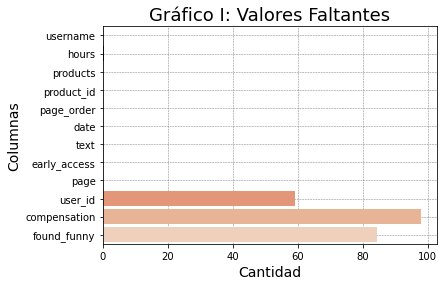

,Total,Percent
compensation,764719,98.1
found_funny,659143,84.6
user_id,461967,59.3
hours,2637,0.3
products,1566,0.2


In [9]:
#Valores faltantes
missing=data_reviews.isna().sum()/len(data_reviews)*100
#se crea otra serie para usar como variable independiente.
columnas=data_reviews.columns
##Gráfico
sns.barplot(y=columnas, x = missing, palette="rocket")
plt.title("Gráfico I: Valores Faltantes",fontsize=18)
plt.xlabel("Cantidad",fontsize=14)
plt.ylabel("Columnas",fontsize=14)
ax = plt.axes()
plt.grid(True,color='grey', linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)
plt.show()
def missing_percentage(df):
    total = data_reviews.isnull().sum().sort_values(ascending = False)[data_reviews.isnull().sum().sort_values(ascending = False) != 0]
    percent = round(data_reviews.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(data_reviews.isnull().sum().sort_values(ascending = False)/len(data_reviews)*100,2) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])
missing_percentage(data_reviews)

Voy a descartar las dos columnas con mayores datos faltantes (Compensation y found_funny) ademas eliminare page_order ya que no brinda informacion que crea significativa

In [10]:
#tomo las columnas relevantes
data_reviews=data_reviews[['user_id','username','product_id','text','hours','products','date','page','early_access']]

#se eliminan los valores faltantes
data_reviews.dropna(subset=['username'], how='all', inplace=True)
data_reviews.dropna(subset=['text'], how='all', inplace=True)
data_reviews.dropna(subset=['hours'], how='all', inplace=True)
data_reviews.dropna(subset=['products'], how='all', inplace=True)

#tipo de datos
data_reviews.dtypes

<ipython-input-10-87dc0885b402>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_reviews.dropna(subset=['username'], how='all', inplace=True)
<ipython-input-10-87dc0885b402>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_reviews.dropna(subset=['text'], how='all', inplace=True)
<ipython-input-10-87dc0885b402>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_reviews.dropna(subset=['hours'], how='all', inplace=True)
<ipyt

user_id          object
username         object
product_id       object
text             object
hours           float64
products        float64
date             object
page              int64
early_access       bool
dtype: object

### Analizaremos las horas jugadas por review

In [11]:
data_reviews.hours.describe().round()

count   775105.0
mean       112.0
std        390.0
min          0.0
25%          4.0
50%         15.0
75%         60.0
max      28164.0
Name: hours, dtype: float64

Se puede ver la presencia de posibles outliers ya que tenemos una media de 112 horas con una maxima de 28164 horas por lo que a continuacion lo trataremos en el grafico para poder analizarlo.

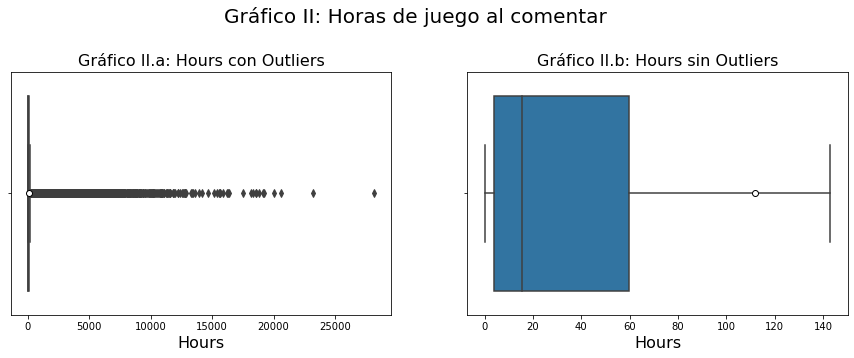

In [12]:
#Boxplot Hours
fig=plt.figure(figsize=(15,5))
plt.suptitle('Gráfico II: Horas de juego al comentar',fontsize=20, ha='center')
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
sns.boxplot(data = data_reviews,x='hours',showfliers=True,showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"}, ax=ax1)
sns.boxplot(data = data_reviews,x='hours',showfliers=False,showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"}, ax=ax2)
ax1.set_title("Gráfico II.a: Hours con Outliers",fontsize=16)
ax2.set_title("Gráfico II.b: Hours sin Outliers",fontsize=16)
ax1.set_xlabel('Hours',fontsize=16)
ax2.set_xlabel('Hours',fontsize=16)
fig.subplots_adjust(top=0.8)
plt.show()

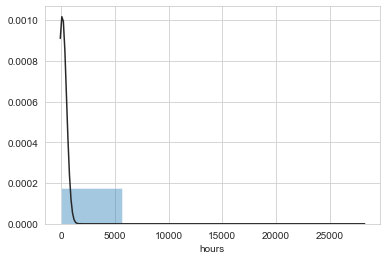

In [13]:
sns.set_style("whitegrid")
x = data_reviews.hours
ax = sns.distplot(x, fit=norm, kde=False, bins=5)

En el grafico anterior podemos ver que hay una marcada cola hacia la derecha por lo que deberiamos utilizar la mediana para ser mas representativos con respecto a los datos de las horas jugadas, el cual es 15 horas.

Para saber si es util eliminarlos o no, cuantificaremos esos posibles outliers para ver si son utiles en cuanto a nuestro analisis.

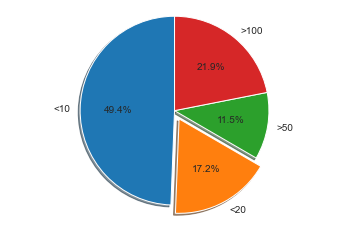

In [14]:
menorQue10=len(data_reviews[data_reviews.hours<10])
menorQue20=len(data_reviews[(data_reviews.hours>10)&(data_reviews.hours<20)])
mayorQue50=len(data_reviews[(data_reviews.hours>50)&(data_reviews.hours<100)])
mayoresQue100=len(data_reviews[data_reviews.hours>100])

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['<10', '<20', '>50', '>100']
sizes = [menorQue10, menorQue20, mayorQue50, mayoresQue100]
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Creo que al descartar los valores mayores a 100 (22%) perderia mucha informacion, asi que no los tratare como outliers.

### Analizaremos a continuacion el user_id

In [15]:
print(data_reviews.user_id.nunique())
print(data_reviews.username.nunique())

260507
537742


In [16]:
print(data_reviews['user_id'].value_counts())

76561198011965365    114
76561198094803808     88
76561197969749884     70
76561198094321628     62
76561198073092169     57
                    ... 
76561198273878110      1
76561198080576690      1
76561198107456016      1
76561198105759112      1
76561198203188814      1
Name: user_id, Length: 260507, dtype: int64


In [17]:
print(data_reviews['username'].value_counts())

123                       213
Alex                      189
Chris                     154
Nick                      142
Matt                      137
                         ... 
csgolive.com Franzy |夏      1
IcarusB                     1
Kennyyy510                  1
hoshistan                   1
detlaf                      1
Name: username, Length: 537742, dtype: int64


Hay muchos user_id que tienen varios usernames por lo que no podriamos utilizarlos directamente. Al haber tantos valores faltantes en user_id lo que podriamos hacer es generar un valor unico por cada username y asi solucionar los NaN de esta columna.

In [18]:
usuarios=data_reviews['username'].unique()
usr_unico=pd.DataFrame(usuarios,columns=['username'])   
finRango=len(usr_unico)+1
user_id=np.array(range(1,finRango,1))
usr_unico['user_id']=user_id
usr_unico

,username,user_id
0,Chaos Syren,1
1,Ariman1,2
2,freakfantom,3
3,The_Cpt_FROGGY,4
4,the_maker988,5
...,...,...
537737,Seikleja,537738
537738,KindAlcoholic,537739
537739,SepticFalcon,537740
537740,RancorZealot,537741


Voy a crear una copia del dataset para comenzar a hacerlo mas liviano y dejar solo las columnas que me van a servir luego y a su vez agregarle la columna con el id unico realizado anteriormente.

In [19]:
reviews = data_reviews

In [20]:
reviews.drop(['date', 'products','text','early_access','page', 'user_id'], axis=1, inplace=True)
reviews.head()

C:\Users\Juani\anaconda3\envs\data_science\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,username,product_id,hours
0,Chaos Syren,725280,0.1
1,Ariman1,328100,13.2
2,freakfantom,725280,0.1
3,The_Cpt_FROGGY,631920,7.8
4,the_maker988,35140,8.2


In [21]:
reviews=reviews.merge(usr_unico, left_on='username', right_on='username')
reviews

,username,product_id,hours,user_id
0,Chaos Syren,725280,0.1,1
1,Ariman1,328100,13.2,2
2,Ariman1,521230,0.5,2
3,Ariman1,493980,2.0,2
4,freakfantom,725280,0.1,3
...,...,...,...,...
775100,Seikleja,252490,80.8,537738
775101,KindAlcoholic,252490,1303.6,537739
775102,SepticFalcon,252490,334.9,537740
775103,RancorZealot,252490,203.5,537741


# Games

In [22]:
data_games.isna().sum()

publisher          8052
genres             3283
app_name              2
title              2050
url                   0
release_date       2067
tags                163
discount_price    31910
reviews_url           2
specs               670
price              1377
early_access          0
id                    2
developer          3299
sentiment          7182
metascore         29458
dtype: int64

<ipython-input-23-f68d9b547a02>:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


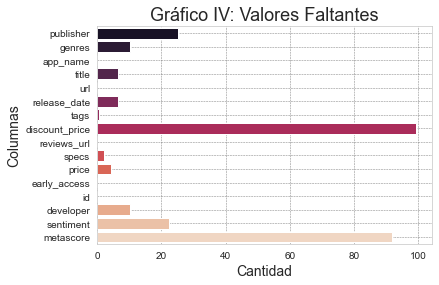

,Total,Percent
discount_price,31910,99.3
metascore,29458,91.7
publisher,8052,25.1
sentiment,7182,22.4
developer,3299,10.3
genres,3283,10.2
release_date,2067,6.4
title,2050,6.4
price,1377,4.3
specs,670,2.1


In [23]:
#Valores faltantes
missing=data_games.isna().sum()/len(data_games)*100
#se crea otra serie para usar como variable independiente.
columnas=data_games.columns

##Gráfico
sns.barplot(y=columnas, x = missing, palette="rocket")
plt.title("Gráfico IV: Valores Faltantes",fontsize=18)
plt.xlabel("Cantidad",fontsize=14)
plt.ylabel("Columnas",fontsize=14)
ax = plt.axes()
plt.grid(True,color='grey', linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)
plt.show()

def missing_percentage(df):
    total = data_games.isnull().sum().sort_values(ascending = False)[data_games.isnull().sum().sort_values(ascending = False) != 0]
    percent = round(data_games.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(data_games.isnull().sum().sort_values(ascending = False)/len(data_games)*100,2) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])
missing_percentage(data_games)

Seleccionare las columnas relevantes para el proyecto y las demas las descartare

In [24]:
games=data_games
games=games[['id','app_name','title','developer','publisher','sentiment','release_date','genres','specs','tags','price']]
games.head()

,id,app_name,title,developer,publisher,sentiment,release_date,genres,specs,tags,price
0,761140,Lost Summoner Kitty,Lost Summoner Kitty,Kotoshiro,Kotoshiro,NaN,2018-01-04,"[Action, Casual, Indie, Simulation, Strategy]",[Single-player],"[Strategy, Action, Indie, Casual, Simulation]",5.0
1,643980,Ironbound,Ironbound,Secret Level SRL,"Making Fun, Inc.",Mostly Positive,2018-01-04,"[Free to Play, Indie, RPG, Strategy]","[Single-player, Multi-player, Online Multi-Pla...","[Free to Play, Strategy, Indie, RPG, Card Game...",Free To Play
2,670290,Real Pool 3D - Poolians,Real Pool 3D - Poolians,Poolians.com,Poolians.com,Mostly Positive,2017-07-24,"[Casual, Free to Play, Indie, Simulation, Sports]","[Single-player, Multi-player, Online Multi-Pla...","[Free to Play, Simulation, Sports, Casual, Ind...",Free to Play
3,767400,弹炸人2222,弹炸人2222,彼岸领域,彼岸领域,NaN,2017-12-07,"[Action, Adventure, Casual]",[Single-player],"[Action, Adventure, Casual]",1.0
4,773570,Log Challenge,NaN,NaN,NaN,NaN,NaN,NaN,"[Single-player, Full controller support, HTC V...","[Action, Indie, Casual, Sports]",3.0


Veremos cuantos juegos hay en total

In [25]:
games.shape

(32135, 11)

Podemos ver que hay 32135 juegos pero sabemos que hay dos datos faltantes en id por lo que serian 32135. A continuacion desecharemos las columnas que no usaremos y eliminaremos esos valores faltantes

In [26]:
games.drop(columns=['title','publisher','genres','release_date','tags','specs','price','developer','sentiment'], inplace=True)
games.dropna(inplace=True)

C:\Users\Juani\anaconda3\envs\data_science\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-26-c300a4e0a41d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  games.dropna(inplace=True)


In [27]:
games.head()

,id,app_name
0,761140,Lost Summoner Kitty
1,643980,Ironbound
2,670290,Real Pool 3D - Poolians
3,767400,弹炸人2222
4,773570,Log Challenge


Por temas de prolijidad vamos a hacer que la columna del id del jugo se llame igual que en el dateset de reviws

In [28]:
games.rename(columns={'id': 'product_id'}, inplace=True)
games

C:\Users\Juani\anaconda3\envs\data_science\lib\site-packages\pandas\core\frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,product_id,app_name
0,761140,Lost Summoner Kitty
1,643980,Ironbound
2,670290,Real Pool 3D - Poolians
3,767400,弹炸人2222
4,773570,Log Challenge
...,...,...
32130,773640,Colony On Mars
32131,733530,LOGistICAL: South Africa
32132,610660,Russian Roads
32133,658870,EXIT 2 - Directions


# Modelo de machine learning (Desarrollo de sistema de recomendacion)

### Seleccion de la metrica
Basado en la informacion que obtuvimos en el analisis de los datos y en la teoria sobre las distintas metricas a utilizar, primero pense que seria mejor utilizar el MAe por la variabilidad que veiamos en las horas jugadas, pero al ver que utilizaremos un ranking de esas horas, la variabilidad baja considerablemente ya que tendremos una escala nueva y por eso tomare el RMSE.

### Creacion de la columna Rating

In [29]:
reviews['rating']=0

In [30]:
rank=[10,20,30,40,50,60,70,80,90]

for valor in rank:
    reviews['rating'][(reviews.hours>(valor-10)) & (reviews.hours<=valor)]=(valor/10)

reviews['rating'][(reviews.hours>=100) ]=10

<ipython-input-30-db55d3029022>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['rating'][(reviews.hours>(valor-10)) & (reviews.hours<=valor)]=(valor/10)


In [31]:
reviews.head()

,username,product_id,hours,user_id,rating
0,Chaos Syren,725280,0.1,1,1
1,Ariman1,328100,13.2,2,2
2,Ariman1,521230,0.5,2,1
3,Ariman1,493980,2.0,2,1
4,freakfantom,725280,0.1,3,1


Hour no sera mas de utilidad por lo que la eliminare

In [32]:
reviews.drop(columns=['hours'], inplace=True)

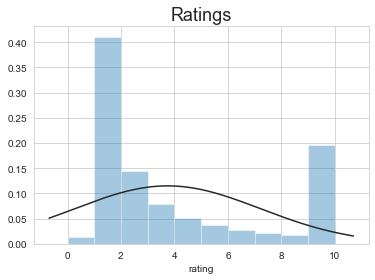

In [33]:
sns.set_style("whitegrid")
x = reviews.rating
plt.title("Ratings",fontsize=18)
ax = sns.distplot(x, fit=norm, kde=False, bins=10)

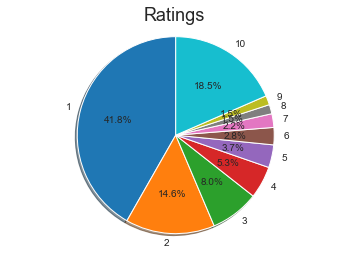

In [34]:
r1=len(reviews[reviews.rating==1])
r2=len(reviews[reviews.rating==2])
r3=len(reviews[reviews.rating==3])
r4=len(reviews[reviews.rating==4])
r5=len(reviews[reviews.rating==5])
r6=len(reviews[reviews.rating==6])
r7=len(reviews[reviews.rating==7])
r8=len(reviews[reviews.rating==9])
r9=len(reviews[reviews.rating==9])
r10=len(reviews[reviews.rating==10])

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = [1,2,3,4,5,6,7,8,9,10]
sizes = [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]
explode = (0,0,0,0,0,0,0,0,0,0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
plt.title("Ratings",fontsize=18)
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Lo que note a lo largo que desarrollaba el proyecto era que habia usuarios que habian realizado varios reviews sobre el mismo juego por lo que tenia en rating varias puntuaciones diferentes o iguales. Lo que hare es contar esas instancias duplicadas y tomar la ultima ya que sera la puntuacion definitiva (por las horas que ya tiene jugadas).

In [35]:
len(reviews)-len(reviews.drop_duplicates())

9420

In [36]:
reviews.drop_duplicates(subset=['product_id', 'user_id'], keep='last', inplace=True)
reviews

,username,product_id,user_id,rating
0,Chaos Syren,725280,1,1
1,Ariman1,328100,2,2
2,Ariman1,521230,2,1
3,Ariman1,493980,2,1
4,freakfantom,725280,3,1
...,...,...,...,...
775100,Seikleja,252490,537738,9
775101,KindAlcoholic,252490,537739,10
775102,SepticFalcon,252490,537740,10
775103,RancorZealot,252490,537741,10


Para mejorar nuestra prediccion sacaremos todos los usuarios que tengan 3 rankeos o menos

In [37]:
filtro=reviews[['user_id','product_id','rating']].groupby(by='user_id').count()
filtro.head()

,product_id,rating
user_id,,
1,1,1
2,3,3
3,1,1
4,27,27
5,1,1


20666


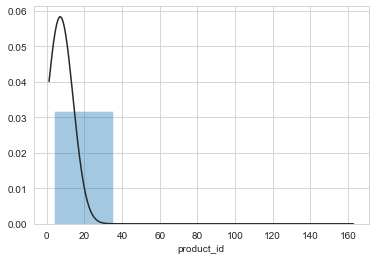

In [38]:
filtro=filtro[(filtro.product_id>3) ]
print(len(filtro))
sns.set_style("whitegrid")
x = filtro.product_id
ax = sns.distplot(x, fit=norm, kde=False, bins=5)

In [39]:
filtro_usuarios=pd.DataFrame(filtro)

In [40]:
filtro= filtro.rename_axis('user_id').reset_index()

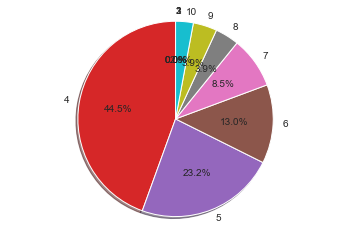

In [41]:
r1=len(filtro[filtro.rating==1])
r2=len(filtro[filtro.rating==2])
r3=len(filtro[filtro.rating==3])
r4=len(filtro[filtro.rating==4])
r5=len(filtro[filtro.rating==5])
r6=len(filtro[filtro.rating==6])
r7=len(filtro[filtro.rating==7])
r8=len(filtro[filtro.rating==9])
r9=len(filtro[filtro.rating==9])
r10=len(filtro[filtro.rating==10])
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = [1,2,3,4,5,6,7,8,9,10]
sizes = [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]
explode = (0,0,0,0,0,0,0,0,0,0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [42]:
grupo_usuarios=filtro['user_id'].values
reviews=reviews[reviews.user_id.isin(grupo_usuarios) ]
reviews

,username,product_id,user_id,rating
5,The_Cpt_FROGGY,631920,4,1
6,The_Cpt_FROGGY,482440,4,1
7,The_Cpt_FROGGY,736860,4,1
8,The_Cpt_FROGGY,493540,4,1
9,The_Cpt_FROGGY,341980,4,1
...,...,...,...,...
695627,Podel,12120,461385,1
705565,WinnB,563560,470697,1
705566,WinnB,427520,470697,8
705567,WinnB,290530,470697,1


### Benchmark - SVD

Modificamos la escala para surprise ya que por defecto es de 0 a 5

In [43]:
reader = Reader(rating_scale=(1, 10))

Creamos el dataset que utilizaremos para la prediccion

In [44]:
data=reviews[['user_id','product_id','rating']]
data.head()

,user_id,product_id,rating
5,4,631920,1
6,4,482440,1
7,4,736860,1
8,4,493540,1
9,4,341980,1


In [45]:
data = Dataset.load_from_df(data[['user_id', 'product_id', 'rating']], reader)

In [46]:
data

Separamos el dataset en train test

In [47]:
trainset, testset = train_test_split(data, test_size=.25)

### Entrenamiento

In [48]:
algo = SVD()

In [49]:
algo.fit(trainset)

In [50]:
predictions = algo.test(testset)

In [51]:
predictions[1]

Prediction(uid=141401, iid='284160', r_ui=1.0, est=3.5849447075381238, details={'was_impossible': False})

### Testeo

In [52]:
#estimamos para un usuario y un juego
#algo.predict(76561198011965359,440)
algo.predict(45948,268500)

Prediction(uid=45948, iid=268500, r_ui=None, est=3.0028931091400484, details={'was_impossible': False})

.

##### Juegos que le gustaron al usuario

In [53]:
usuario = 2889
rating = 7
# Filtramos data_reviews
df_user = reviews[(reviews['user_id'] == usuario) & (reviews['rating'] >= rating)]
#Reseteamos elindex
df_user = df_user.reset_index(drop=True)
# hacemos unjoin df_users y data_games
df_user = pd.merge(left=df_user,right=games, left_on='product_id', right_on='product_id')
# Listamos el resultado
print(df_user.shape)
df_user.head()

(30, 5)


,username,product_id,user_id,rating,app_name
0,123,271590,2889,7,Grand Theft Auto V
1,123,445220,2889,10,Avorion
2,123,220200,2889,10,Kerbal Space Program
3,123,263280,2889,8,SPINTIRES™
4,123,242680,2889,10,Nuclear Throne


.

##### Juegos que no le gustaron al usuario

In [54]:
usuario = 2889
rating = 6
# Filtramos data_reviews
df_user = reviews[(reviews['user_id'] == usuario) & (reviews['rating'] <= rating)]
#Reseteamos elindex
df_user = df_user.reset_index(drop=True)
# hacemos unjoin df_users y data_games
df_user = pd.merge(left=df_user,right=games, left_on='product_id', right_on='product_id')
# Listamos el resultado
print(df_user.shape)
df_user.head()

(81, 5)


,username,product_id,user_id,rating,app_name
0,123,35720,2889,4,Trine 2: Complete Story
1,123,337000,2889,3,Deus Ex: Mankind Divided
2,123,389730,2889,2,TEKKEN 7
3,123,307780,2889,5,Mortal Kombat X
4,123,371520,2889,1,Bounty Train


.

##### Juegos que ya probo e hizo su review

In [55]:
usuario_jugado = reviews[reviews['user_id'] == usuario]
print(usuario_jugado.shape)
usuario_jugado.head()

(111, 4)


,username,product_id,user_id,rating
12508,123,35720,2889,4
12509,123,271590,2889,7
12510,123,337000,2889,3
12511,123,389730,2889,2
12512,123,307780,2889,5


Crearemos un dataset donde se guardaran las recomendaciones, para ello borraremos los juegos que ya hizo su review

In [56]:
recomendaciones_usuario = games.copy()
recomendaciones_usuario.set_index('product_id',inplace=True)
print(recomendaciones_usuario.shape)
recomendaciones_usuario.head()

(32132, 1)


,app_name
product_id,
761140,Lost Summoner Kitty
643980,Ironbound
670290,Real Pool 3D - Poolians
767400,弹炸人2222
773570,Log Challenge


In [57]:
recomendaciones_usuario.drop(usuario_jugado.product_id,inplace = True)
recomendaciones_usuario = recomendaciones_usuario.reset_index()
print(recomendaciones_usuario.shape)
recomendaciones_usuario.head()

(32021, 2)


,product_id,app_name
0,761140,Lost Summoner Kitty
1,643980,Ironbound
2,670290,Real Pool 3D - Poolians
3,767400,弹炸人2222
4,773570,Log Challenge


Recomendamos

In [58]:
recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['product_id'].apply(lambda x: algo.predict(usuario, x).est)

In [59]:
recomendaciones_usuario = recomendaciones_usuario.sort_values('Estimate_Score', ascending=False)
recomendaciones_usuario

,product_id,app_name,Estimate_Score
58,4000,Garry's Mod,10.0
1034,730,Counter-Strike: Global Offensive,10.0
7951,232090,Killing Floor 2,10.0
385,48700,Mount & Blade: Warband,10.0
29396,39210,FINAL FANTASY XIV Online,9.9
...,...,...,...
28653,280740,Aperture Tag: The Paint Gun Testing Initiative,1.0
30397,221640,Super Hexagon,1.0
26485,374570,Kung Fury,1.0
605,55100,Homefront,1.0


### Evaluacion

Como ya dijimos utilizaremos el RMSE asi que lo calculamos

In [60]:
accuracy.rmse(predictions)

RMSE: 2.4803


2.480341031881122

### Optimizacion de parametros

In [61]:
from surprise.model_selection import cross_validate

rmse_test_means = []
factores = [1,5,15,25,30]

for factor in factores:
    print(f'\nNúmero de Factores: {factor}')
    algo = SVD(n_factors=factor)
    cv = cross_validate(algo, data, measures=['RMSE'], cv = 3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))


Número de Factores: 1
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    2.4845  2.4983  2.4780  2.4869  0.0085  
Fit time          1.44    1.33    1.62    1.46    0.12    
Test time         0.26    0.26    0.45    0.32    0.09    

Número de Factores: 5
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    2.5212  2.5155  2.5123  2.5163  0.0037  
Fit time          1.43    1.38    1.71    1.50    0.14    
Test time         0.41    0.45    0.46    0.44    0.02    

Número de Factores: 15
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    2.5106  2.5084  2.5146  2.5112  0.0026  
Fit time          2.16    1.96    2.37    2.17    0.17    
Test time         0.56    0.27    0.43    0.42    0.12    

Número de Factores: 25
Evaluating RMSE of algorithm SVD on 3 split(s).

  

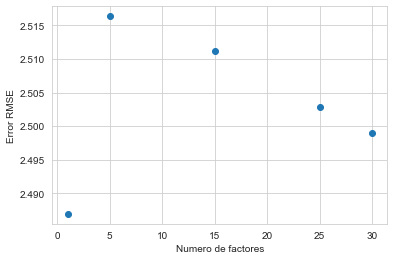

In [62]:
plt.scatter(factores, rmse_test_means)
plt.xlabel('Numero de factores')
plt.ylabel('Error RMSE')
plt.show()

In [63]:
%%time
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors':[1,2,3],'n_epochs': [25,27,30], 'lr_all': [0.0015, 0.002],
              'reg_all': [0.01, 0.015,0.02]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5, n_jobs = -1, joblib_verbose=5)
gs.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.0min


Wall time: 3min 28s


[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  3.5min finished


In [64]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

2.4437928078893285
{'n_factors': 1, 'n_epochs': 27, 'lr_all': 0.002, 'reg_all': 0.02}


### SVD++

In [65]:
%%time

from surprise import SVDpp
algo_pp = SVDpp()
algo_pp.fit(trainset)

predictions_pp = algo_pp.test(testset)

#Probamos
algo_pp.predict(45948,268500)

Wall time: 24.1 s


Prediction(uid=45948, iid=268500, r_ui=None, est=3.0028931091400484, details={'was_impossible': False})

In [66]:
accuracy.rmse(predictions_pp)

RMSE: 2.6669


2.666857849617351

In [67]:
from surprise.model_selection import cross_validate

rmse_test_means = []
factores = [1,2,4]

for factor in factores:
    print(f'\nNúmero de Factores: {factor}')
    algo = SVDpp(n_factors=factor)
    cv = cross_validate(algo, data, measures=['RMSE'], cv = 3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))


Número de Factores: 1
Evaluating RMSE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    2.5795  2.5849  2.5887  2.5844  0.0038  
Fit time          13.45   11.57   12.79   12.61   0.78    
Test time         1.24    0.91    1.27    1.14    0.16    

Número de Factores: 2
Evaluating RMSE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    2.6435  2.6254  2.6495  2.6395  0.0103  
Fit time          12.01   12.59   11.18   11.93   0.58    
Test time         1.07    0.97    0.89    0.98    0.07    

Número de Factores: 4
Evaluating RMSE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    2.6753  2.6982  2.6798  2.6845  0.0099  
Fit time          13.44   14.47   11.95   13.29   1.03    
Test time         1.18    1.20    1.05    1.14    0.07    


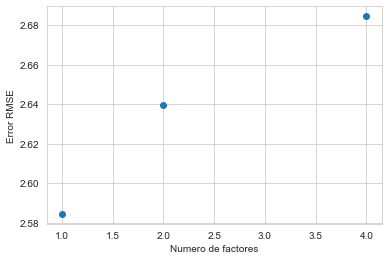

In [68]:
plt.scatter(factores, rmse_test_means)
plt.xlabel('Numero de factores')
plt.ylabel('Error RMSE')
plt.show()

In [69]:
%%time
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors':[1],'n_epochs': [25,27,30], 'lr_all': [0.0015, 0.002],
              'reg_all': [0.01, 0.015,0.02]}
gs = GridSearchCV(SVDpp, param_grid, measures=['rmse'], cv=5, n_jobs = -1, joblib_verbose=5)
gs.fit(data)
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   55.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  6.0min


2.46839241132536
{'n_factors': 1, 'n_epochs': 27, 'lr_all': 0.0015, 'reg_all': 0.01}
Wall time: 9min 59s


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 10.0min finished


## Conclusion


A partir de correr los dos modelos y optimizar hiperparámetros de cada uno de ellos podemos ver en este caso que se desempeña mejor el modelo SVD con un RMSE de 2.44 y un tiempo mucho menor de ejecucion. Los hiperparámetros seleccionados son:

   * n_factors: 1,

   * n_epochs: 27

   * lr_all: 0.002,

   * reg_all: 0.02

## Investigacion

### Propuesta para continuar con el analisis y mejora de los modelos

* Aplicar tecnicas de lenguaje natural para mejorar la prediccion

Como vimos a lo largo de este proyecto, utilizamos un rating creado por nosotros en base a las horas jugadas por cada usuario, este fue el puntapie inicial para generar una prediccion pero si volvemos al dataset podemos observar que hay mas informacion que pdoria, posiblemente, mejorar nuestro modelo.
Para esto desplegaremos el dataset asi vemos que informacion puede sernos de utilidad:

In [70]:
datain.head()

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,nan
1,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,nan
2,freakfantom,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,nan
3,The_Cpt_FROGGY,7.8,2217.0,631920,0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False,1,76561198003030375,Product received for free,nan
4,the_maker988,8.2,18.0,35140,7,2018-01-02,"This game was way to linear for me, and compar...",False,1,76561198353396844,NaN,nan


y analizar sus valores nulos para comprender mas sobre cada variable

In [71]:
datain.isna().sum()

username             0
hours             2637
products          1566
product_id           0
page_order           0
date                 0
text                 0
early_access         0
page                 0
user_id         461967
compensation    764719
found_funny     659143
dtype: int64

Lo primero que podemos destacar y que nos servira para el proceso que planteamos es el atributo **text** que es donde el usuario escribe su opinion sobre el juego en una breve descripcion. Si vemos tiene poco valores nulos lo cual es de gran ayuda para nuestro proposito. A travez del la tecnica de lenguaje natural podemos inferir en palabras claves que aparecen para realzar los gustos de las personas para diferentes jugos. Para mostrar de manera grafica esto voy a tomar un usuario 

In [72]:
datain.head(1)

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,nan


El primer usuario por ejemplo tiene una frase "not be acceptable" lo cual indicaria un disgusto en su review. Podriamos ver si utilizando el atributo **found funny** damos mayor importancia a ese comentario ya que ha sido "validado" por otros usuarios.

Ahora veremos si podemos sacar mas informacion del dataset de games: 

In [73]:
data_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.5,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],5.0,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",nan,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",nan,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.8,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],1.0,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.8,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",3.0,False,773570,NaN,NaN,NaN


Podriamos utilizar aqui tambien **tags** para complejizar el modelo de prediccion y ser mas exactos, ya que eso determina el genero al que pertenecen los juegos y brindan mas informacion para la recomendacion. 
lo mismo podriamos hacer con **specs** ya que asi podriamos recomendar juegos single player, multiplayer, online etc a gente que realmente le guste este tipo de juegos y no uno al que no acostumbra.

### Resultado esperado: 

Se espera con las recomendaciones planteadas, complejizar el modelo de recomendacion a traves de NLP entendiendo asi las preferencias reales y expresadas por el usuario, en el caso de **text**  y no tan implicitas como pueden ser las horas jugadas. Hay por supuesto otras recomendaciones que siguen siendo algo implicitas como el modo de juego o la categoria a la que pertenece que personalizan aun mas la recomendacion.
No estoy seguro que la implementacion de este modelo se vea reflejado directamente en la metrica a utilizar pero creo que si en cuanto a la precision real del modelo en base a gustos mas personalizados. Para esto se podria ver de aplicar metricas como el MPR y MAP que estan basadas en el orden para ver la relevancia que cada usuario le da a la recomendacion o al juego en si y ver mejoras en ese indicador en particular. 


##### Quinteros Juan Ignacio